Spectrogram code extracted from: https://github.com/vijay033/Noise-Suppression-Auto-Encoder/blob/master/ProcessWav.ipynb

In [1]:
# TensorFlow Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose, Cropping2D, ZeroPadding2D
from keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

# Other
import os
import glob
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.io import wavfile
from IPython.display import Audio

2024-05-08 18:24:16.562569: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-08 18:24:16.604257: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Spectrogram Functions

In [3]:
def amplifyMagnitudeByLog(d):
    return 188.301 * math.log10(d + 1)

def weakenAmplifiedMagnitude(d):
    return math.pow(10, d/188.301)-1

def recoverLinearScale(rgbArray, magnitudeMin, magnitudeMax, phaseMin, phaseMax):
    width = rgbArray.shape[1]
    height = rgbArray.shape[0]
    # print(phaseMax,phaseMin)
    magnitudeVals = rgbArray[:,:,0].astype(float) + rgbArray[:,:,1].astype(float)
    phaseVals = rgbArray[:,:,2].astype(float)
    phaseRange = phaseMax - phaseMin
    magnitudeRange = magnitudeMax - magnitudeMin
    
    for w in range(width):
        for h in range(height):
            phaseVals[h,w] = (phaseVals[h,w] / 255 * phaseRange) + phaseMin
            magnitudeVals[h,w] = weakenAmplifiedMagnitude(magnitudeVals[h,w])
            magnitudeVals[h,w] = (magnitudeVals[h,w] / (255*2) * magnitudeRange) + magnitudeMin
    return magnitudeVals, phaseVals

def recoverSignalFromSpectrogram(numpyarray):
    data = np.array(numpyarray, dtype='uint8')
    width = data.shape[1]
    height = data.shape[0]

    magnitudeVals, phaseVals = recoverLinearScale(data, magnitudeMin, magnitudeMax, phaseMin, phaseMax)
        
    recovered = np.zeros(WINDOW_LENGTH * width // 2 + WINDOW_STEP, dtype=np.int16)
    recovered = np.array(recovered,dtype=np.int16)
    
    for w in range(width):
        toInverse = np.zeros(height, dtype=np.complex_)
        for h in range(height):
            magnitude = magnitudeVals[height-h-1,w]
            phase = phaseVals[height-h-1,w]
            toInverse[h] = magnitude * math.cos(phase) + (1j * magnitude * math.sin(phase))
        signal = np.fft.irfft(toInverse)
        recovered[w*WINDOW_STEP:w*WINDOW_STEP + WINDOW_LENGTH] += signal[:WINDOW_LENGTH].astype(np.int16)
    return recovered


# Use these initializations for recovery from spectrogram
FFT_LENGTH = 512
WINDOW_LENGTH = 512
WINDOW_STEP = int(WINDOW_LENGTH / 2)
phaseMax = 3.141592653589793 
phaseMin = -3.141592653589793
magnitudeMax = 2211683.973249525
magnitudeMin = 0.0
rate = 16000

## Data Loading

In [4]:
files_train = glob.glob("/data/csc6621/24-team-c/dataset/LibriNoise_Train_Test_NPY/mat_train/*.npy")
files_train_y = glob.glob("/data/csc6621/24-team-c/dataset/LibriNoise_Train_Test_NPY/mat_ytrain/*.npy")
files_test = glob.glob("/data/csc6621/24-team-c/dataset/LibriNoise_Train_Test_NPY/mat_test/*.npy")
files_test_y = glob.glob("/data/csc6621/24-team-c/dataset/LibriNoise_Train_Test_NPY/mat_ytest/*.npy")

In [5]:
import numpy as np
import math
import os
from scipy.io.wavfile import write

# Use these initializations for recovery from spectrogram
FFT_LENGTH = 512
WINDOW_LENGTH = 512
WINDOW_STEP = int(WINDOW_LENGTH / 2)
phaseMax = 3.141592653589793 
phaseMin = -3.141592653589793
magnitudeMax = 2211683.973249525
magnitudeMin = 0.0
rate = 16000
def recoverSignalFromSpectrogram(numpyarray):
    data = np.array(numpyarray, dtype='uint8')
    width = data.shape[1]
    height = data.shape[0]

    magnitudeVals, phaseVals = recoverLinearScale(data, magnitudeMin, magnitudeMax, phaseMin, phaseMax)
        
    recovered = np.zeros(WINDOW_LENGTH * width // 2 + WINDOW_STEP, dtype=np.int16)
    recovered = np.array(recovered,dtype=np.int16)
    
    for w in range(width):
        toInverse = np.zeros(height, dtype=np.complex_)
        for h in range(height):
            magnitude = magnitudeVals[height-h-1,w]
            phase = phaseVals[height-h-1,w]
            toInverse[h] = magnitude * math.cos(phase) + (1j * magnitude * math.sin(phase))
        signal = np.fft.irfft(toInverse)
        recovered[w*WINDOW_STEP:w*WINDOW_STEP + WINDOW_LENGTH] += signal[:WINDOW_LENGTH].astype(np.int16)
    return recovered

def save_as_wav(audio_data, file_path, folder):
    # Ensure the "imageWavs" directory exists
    os.makedirs(f"/home/gravesr/AudioFiltering/WavesFromSpecs/{folder}", exist_ok=True)
    # Extract file name
    file_name = os.path.basename(file_path)
    # Remove the ".npy" extension
    file_name = os.path.splitext(file_name)[0]
    # Construct the WAV file path
    wav_file_path = os.path.join(f"/home/gravesr/AudioFiltering/WavesFromSpecs/{folder}", file_name + ".wav")
    # Sample rate (you need to replace this with the actual sample rate of your audio)
    sample_rate = rate  # Example sample rate
    # Save the audio data as a WAV file
    write(wav_file_path, sample_rate, audio_data)

for file_path in files_test:
    spectrogram = np.load(file_path)
    audio = recoverSignalFromSpectrogram(spectrogram)
    save_as_wav(audio, file_path, "test")
for file_path in files_test_y:
    spectrogram = np.load(file_path)
    audio = recoverSignalFromSpectrogram(spectrogram)
    save_as_wav(audio, file_path, "y_test")
    
for file_path in files_train:
    spectrogram = np.load(file_path)
    audio = recoverSignalFromSpectrogram(spectrogram)
    save_as_wav(audio, file_path, "train")
for file_path in files_train_y:
    spectrogram = np.load(file_path)
    audio = recoverSignalFromSpectrogram(spectrogram)
    save_as_wav(audio, file_path, "y_train")

Lets try to make datasets like we did for our original wav splits to make sure it doenst fail.

In [6]:
# Function to read WAV files and create datasets
def create_dataset(clean_paths, noisy_paths, batch_size=64, shuffle=True, audio_length=16000):
    def load_wav(file_path):
        # Read in a file
        audio = tf.io.read_file(file_path)
        # Decode to tensor
        audio, _ = tf.audio.decode_wav(audio, desired_channels=1)
        # Make it mono
        audio = tf.squeeze(audio, axis=-1)
        # Pad it to 16128
        # For some reason this step needs to be VERY explicit
        audio = tf.pad(audio, paddings=[[0, audio_length - tf.shape(audio)[0]]], mode='CONSTANT', constant_values=0)
        return audio 
    # Get a list of paths pointing to individual samples wav files
    clean_dataset = tf.data.Dataset.from_tensor_slices(clean_paths)
    # replace those paths with the audio actually stored there
    clean_dataset = clean_dataset.map(load_wav)
    # Get a list of paths pointing to individual samples wav files
    noisy_dataset = tf.data.Dataset.from_tensor_slices(noisy_paths)
    # replace those paths with the audio actually stored there
    noisy_dataset = noisy_dataset.map(load_wav)
    # Zip the clean and noisy datasets together
    dataset = tf.data.Dataset.zip((noisy_dataset, clean_dataset))
    # Shuffly the data so all the same samples arent stuck together
    if shuffle:
        dataset = dataset.shuffle(100)
    # Batch the data and drop the remainders so every batch is the same
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

# Function to get the length of audio files
def get_audio_length(paths):
    audio_lengths = []
    for path in tqdm(paths):
        audio = tf.io.read_file(path)
        audio, _ = tf.audio.decode_wav(audio, desired_channels=1)
        audio_lengths.append(audio.shape[0])
    return audio_lengths
# Paths to train and test folders
train_clean_paths = glob.glob('WavesFromSpecs/y_train/*.wav')
train_noisy_paths = glob.glob('WavesFromSpecs/train/*.wav')
test_clean_paths = glob.glob('WavesFromSpecs/y_test/*.wav')
test_noisy_paths = glob.glob('WavesFromSpecs/test/*.wav')

# Create train and test datasets
train_dataset = create_dataset(train_clean_paths, train_noisy_paths, batch_size=16, audio_length=rate) # 16 one second sample batches
test_dataset = create_dataset(test_clean_paths, test_noisy_paths, batch_size=16, audio_length=rate) # 16 one second sample batches

2024-05-08 18:24:18.959872: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 716 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:61:00.0, compute capability: 7.5


Lets examine one of the decoded wavs to make sure it worked

In [7]:
audio, sample_rate = tf.audio.decode_wav(tf.io.read_file("WavesFromSpecs/test/1034-121119-0049.wav"))

print("Sample Rate:", sample_rate)
print("Audio Shape:", audio.shape)

Sample Rate: tf.Tensor(16000, shape=(), dtype=int32)
Audio Shape: (16128, 1)


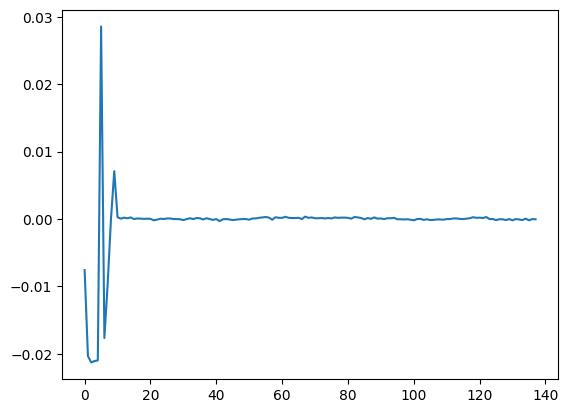

In [8]:
plt.plot(audio[15990:])

The last 128 of the audiofiles is just dead noise brought about by the recovery program.